<a href="https://colab.research.google.com/github/sushithadevaraju/sentiment-analysis-of-imdb/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing file

In [1]:
from google.colab import files

uploaded = files.upload()


Saving IMDB Dataset.csv to IMDB Dataset (3).csv


Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


Load the Dataset

In [3]:
#Load the dataset
mov = pd.read_csv('IMDB Dataset.csv')

#Display the first few rows
print(mov.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Data preprocessing

In [4]:
#Download the punkt tokenizer
nltk.download('punkt')

#Checking for null values
print(mov.isnull().sum())

#preprocessing
def preprocess_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = ' '.join(text)
    return text

#Apply preprocessing to the dataset
mov['review'] = mov['review'].apply(preprocess_text)

#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mov['review'], mov['sentiment'], test_size=0.2, random_state=42)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


review       0
sentiment    0
dtype: int64


Feature Extraction

In [5]:
#Create TF-IDF vectors for the text data
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()


In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

# Checking for null values
print(mov.isnull().sum())

review       0
sentiment    0
dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing: Tokenization, Lemmatization, and Stemming

In [8]:
#Initializing tools for stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

#Preprocessing function
def preprocess_text(text):
    #Convert to lowercase
    text = text.lower()

    #Tokenization
    tokens = word_tokenize(text)

    #Removing stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    #Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Stemming
    stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]

    #Joining tokens back into a string
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

#Apply preprocessing to the dataset
mov['review'] = mov['review'].apply(preprocess_text)

Model Implementation (Logistic Regression)


In [9]:
#Encode target labels
y_train = y_train.apply(lambda x: 1 if x == 'positive' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'positive' else 0)

#Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

#Predicting the model
y_pred = lr_model.predict(X_test_tfidf)

#Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8938
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



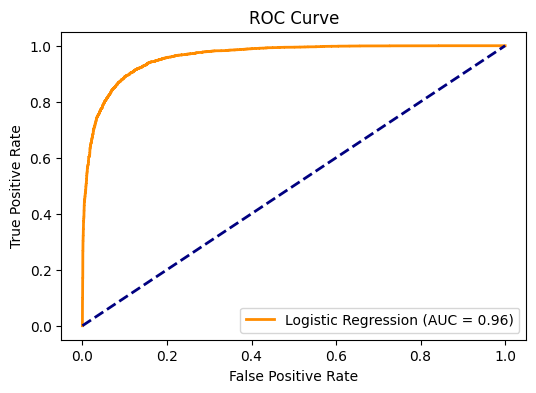

In [41]:
from sklearn.metrics import roc_curve, auc

#Predicting probabilities
y_pred_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]  # Logistic Regression probabilities
#Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob_lr)
#Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
#Plotting curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [22]:
!pip install scikit-learn==1.2.2 eli5


In [23]:
import eli5


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [26]:
from sklearn.preprocessing import LabelEncoder
from eli5.sklearn import PermutationImportance
import eli5

# Step 1: Encode the true labels
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)  # This will convert "positive" and "negative" to 1 and 0

# Step 2: Fit Permutation Importance
perm = PermutationImportance(lr_model, random_state=1).fit(X_test_tfidf, y_test_encoded)

# Step 3: Display top influencing features
eli5.show_weights(perm, feature_names=tfidf.get_feature_names_out(), top=10)


Weight,Feature
0.0067 ± 0.0023,great
0.0060 ± 0.0003,bad
0.0049 ± 0.0008,worst
0.0027 ± 0.0012,excellent
0.0026 ± 0.0006,waste
0.0024 ± 0.0019,boring
0.0023 ± 0.0009,awful
0.0018 ± 0.0008,terrible
0.0016 ± 0.0018,poor
0.0015 ± 0.0015,you


Model Implementation (LSTM)

In [10]:

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

# Defining LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", accuracy)

# Predict using the LSTM model
y_pred_prob = model.predict(X_test_pad)
y_pred_lstm = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy, F1 score, and precision
accuracy = accuracy_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)
precision = precision_score(y_test, y_pred_lstm)

print("LSTM Model Performance:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 312s 495ms/step - accuracy: 0.7292 - loss: 0.5237 - val_accuracy: 0.8211 - val_loss: 0.4424
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 321s 495ms/step - accuracy: 0.8052 - loss: 0.4406 - val_accuracy: 0.8596 - val_loss: 0.3409
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 309s 474ms/step - accuracy: 0.8611 - loss: 0.3329 - val_accuracy: 0.8661 - val_loss: 0.3286
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 310s 497ms/step - accuracy: 0.8739 - loss: 0.3060 - val_accuracy: 0.8860 - val_loss: 0.2908
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 303s 466ms/step - accuracy: 0.9005 - loss: 0.2523 - val_accuracy: 0.8635 - val_loss: 0.3331
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.8618 - loss: 0.3348
Test Accuracy: 0.8634999990463257
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step
LSTM Model Performance:
Accuracy: 0.8635
F1 Score: 0.8755810773858353
Precision: 0.809676331759946


Implementing Naive Bayes Model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(mov['review'], mov['sentiment'], test_size=0.2, random_state=42)


In [12]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)


MultinomialNB()

In [13]:
#Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

#Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

#Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Accuracy: 0.852
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4961
    positive       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:
 [[4234  727]
 [ 753 4286]]


Implementing SVM Model

In [14]:
from sklearn.svm import SVC

#Preprocessing (tokenization, lowercasing)
mov['review'] = mov['review'].str.lower()

#Splitng the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mov['review'], mov['sentiment'], test_size=0.2, random_state=42)
#Training the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

#Making predictions
y_pred = svm_model.predict(X_test_tfidf)

#Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8941
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.89      0.90      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
 [[4384  577]
 [ 482 4557]]


Visualization

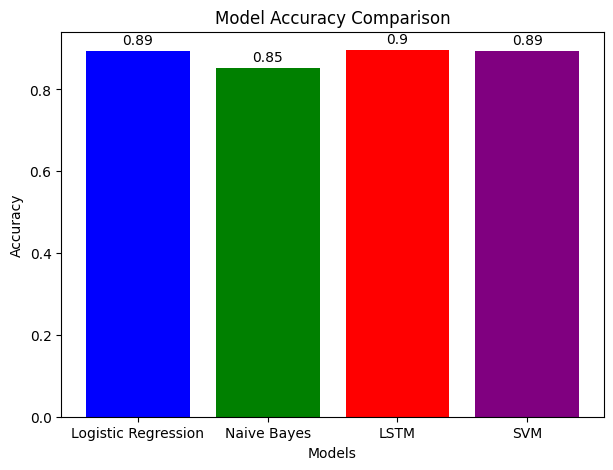

In [19]:

#These are the accuracies obtained from the models
logistic_regression_accuracy = 0.8938
naive_bayes_accuracy = 0.852
lstm_accuracy = 0.896399974822998
svm_accuracy = 0.8941

#Creating a dictionary of model names and their corresponding accuracies
model_accuracies = {
    'Logistic Regression': logistic_regression_accuracy,
    'Naive Bayes': naive_bayes_accuracy,
    'LSTM': lstm_accuracy,
    'SVM': svm_accuracy

}

#Extracting the model names and accuracies for plotting
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

#Creating a bar chart
plt.figure(figsize=(7,5))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])

#Adding title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

#Adding the accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

#Display's the plot
plt.show()


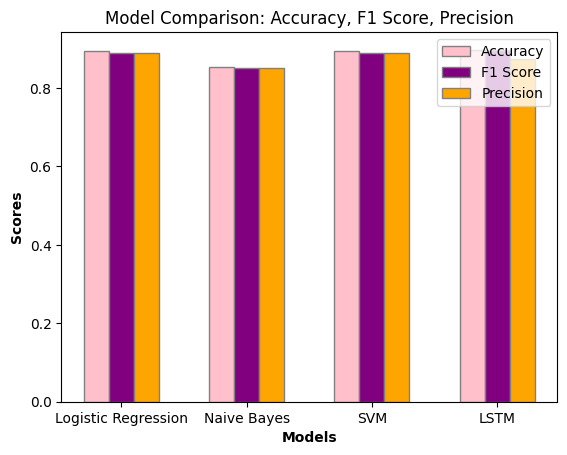

In [20]:
#Metrics of the models:
metrics = {
    "Logistic Regression": {"accuracy": 0.8938, "f1_score": 0.89, "precision": 0.89},
    "Naive Bayes": {"accuracy": 0.852, "f1_score": 0.85, "precision": 0.85},
    "SVM": {"accuracy": 0.8941, "f1_score": 0.89, "precision": 0.89},
    "LSTM": {"accuracy": 0.896399974822998, "f1_score": 0.8972179289026275, "precision": 0.8740824392998306},
}

#Names of the models
models = list(metrics.keys())

#Metrics
accuracies = [metrics[model]["accuracy"] for model in models]
f1_scores = [metrics[model]["f1_score"] for model in models]
precisions = [metrics[model]["precision"] for model in models]

#Creating bar width
bar_width = 0.2

#Seting positions for the bars
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

#Plot bars
plt.bar(r1, accuracies, color='pink', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, f1_scores, color='purple', width=bar_width, edgecolor='grey', label='F1 Score')
plt.bar(r3, precisions, color='orange', width=bar_width, edgecolor='grey', label='Precision')

#Adding labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.title('Model Comparison: Accuracy, F1 Score, Precision')

#Adding legend
plt.legend()

#Displaying plot
plt.show()


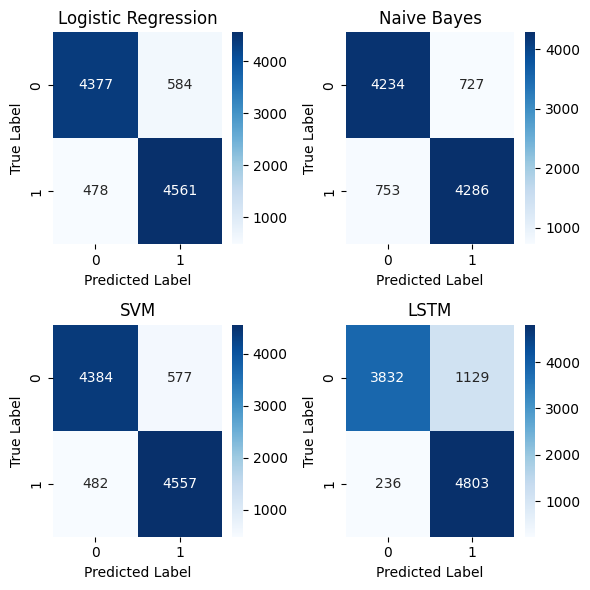

In [21]:
#Converting y_test to numeric labels
y_test_numeric = y_test.apply(lambda x: 1 if x == 'positive' else 0)

#Prediction using all models
y_pred_lr = lr_model.predict(X_test_tfidf)  # Logistic Regression
y_pred_nb = nb_model.predict(X_test_tfidf)  # Naive Bayes
y_pred_svm = svm_model.predict(X_test_tfidf)  # SVM

#Map string predictions to numeric values (0 and 1)
y_pred_nb = [1 if label == 'positive' else 0 for label in y_pred_nb]
y_pred_svm = [1 if label == 'positive' else 0 for label in y_pred_svm]


#Computing confusion matrices
cm_lr = confusion_matrix(y_test_numeric, y_pred_lr)
cm_nb = confusion_matrix(y_test_numeric, y_pred_nb)
cm_svm = confusion_matrix(y_test_numeric, y_pred_svm)
cm_lstm = confusion_matrix(y_test_numeric, y_pred_lstm)

#Plotting all confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

#Confusion matrix for Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title("Logistic Regression")
axes[0, 0].set_xlabel("Predicted Label")
axes[0, 0].set_ylabel("True Label")

#Confusion matrix for Naive Bayes
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title("Naive Bayes")
axes[0, 1].set_xlabel("Predicted Label")
axes[0, 1].set_ylabel("True Label")

#Confusion matrix for SVM
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title("SVM")
axes[1, 0].set_xlabel("Predicted Label")
axes[1, 0].set_ylabel("True Label")

#Confusion matrix for LSTM
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title("LSTM")
axes[1, 1].set_xlabel("Predicted Label")
axes[1, 1].set_ylabel("True Label")

plt.tight_layout()

#Displaying plot
plt.show()


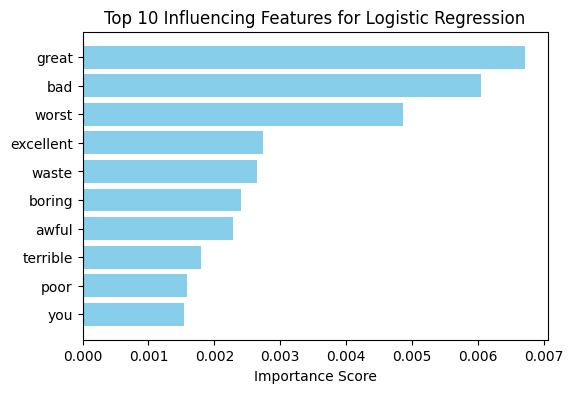

In [34]:
#feature names and their corresponding importance weights
feature_importances = perm.feature_importances_
feature_names = tfidf.get_feature_names_out()

#Get the top 10 features with the highest importance scores
top_n = 10
top_indices = feature_importances.argsort()[-top_n:][::-1]  #Indices of top features

#Preparing data for plotting
top_features = [feature_names[i] for i in top_indices]
top_importances = feature_importances[top_indices]

#Plotting graph
plt.figure(figsize=(6, 4))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Influencing Features for Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


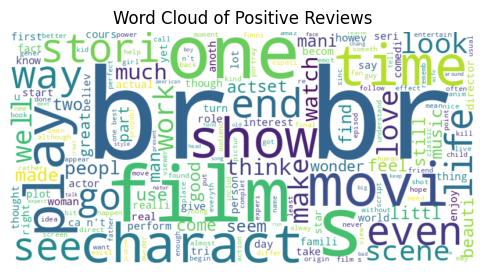

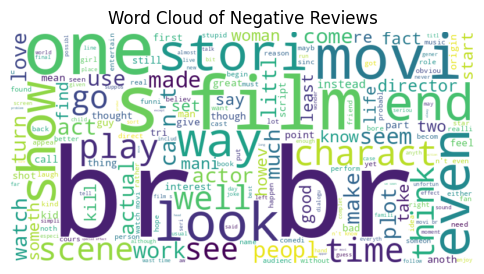

In [37]:
from wordcloud import WordCloud

# Word Cloud for Positive Reviews
positive_reviews = ' '.join(mov[mov['sentiment'] == 'positive']['review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud of Positive Reviews')
plt.axis('off')
plt.show()

# Word Cloud for Negative Reviews
negative_reviews = ' '.join(mov[mov['sentiment'] == 'negative']['review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud of Negative Reviews')
plt.axis('off')
plt.show()


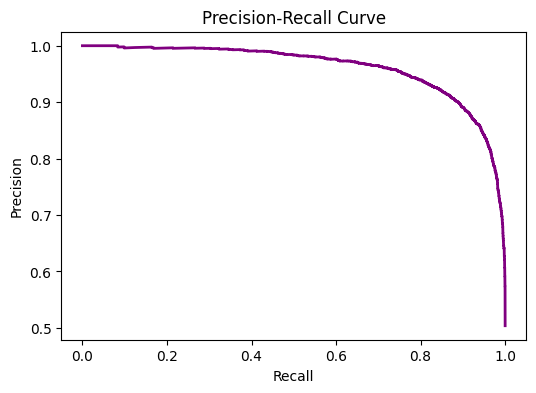

In [43]:
from sklearn.metrics import precision_recall_curve

#Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_pred_prob_lr)
#Plot the curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
